In [6]:
import librosa
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
import os

from birdclassification.preprocessing.utils import *

In [7]:
input_filename = '/media/jacek/E753-A120/recordings_30/Apus apus/103552.mp3'
sr = 32000
n_fft = 512 
hop_length = 3 * 128
sample_length = 3

In [8]:
def plot_librosa_spectrogram(y):
  M_db = librosa.power_to_db(y, ref=np.max)
  spectrogram = (M_db + 80) / 80
  return array_to_image(spectrogram)

In [9]:
def plot_torch_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [10]:
y_librosa, sr = librosa.load(input_filename, sr=sr)
y_librosa, sr

(array([-8.8382212e-06, -2.1488815e-06,  2.5660853e-05, ...,
        -3.4472359e-06,  1.2923912e-05, -2.3952089e-07], dtype=float32),
 32000)

In [11]:
y_torch, sr2 = torchaudio.load(input_filename)
y_torch, sr2

(tensor([[-5.9474e-07, -8.2828e-06,  3.1757e-05,  ...,  1.9226e-05,
          -1.5389e-06,  8.8210e-06],
         [-1.7082e-05,  3.9851e-06,  1.9564e-05,  ...,  1.8920e-05,
          -5.4965e-06, -5.7358e-06]]),
 32000)

In [12]:
if sr2 != sr:
  y_torch = torchaudio.transforms.Resample(orig_freq=sr2, new_freq=sr)(y_torch)

y_torch, sr

(tensor([[-5.9474e-07, -8.2828e-06,  3.1757e-05,  ...,  1.9226e-05,
          -1.5389e-06,  8.8210e-06],
         [-1.7082e-05,  3.9851e-06,  1.9564e-05,  ...,  1.8920e-05,
          -5.4965e-06, -5.7358e-06]]),
 32000)

In [13]:
@timer
def create_spectrogram_torch(y):
  transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, f_min=150, f_max=15000, n_mels=64)
  return transform(y)[0]

@timer
def create_spectrogram_librosa(y):
  return librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=64, fmin=150, fmax=15000)

Function: 'create_spectrogram_torch', execution time: 0.047501564025878906


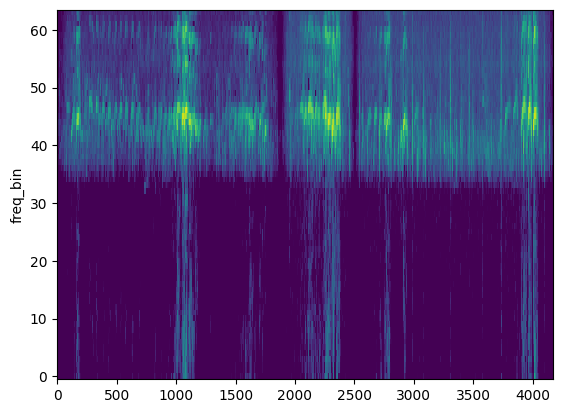

In [14]:
spectrogram_torch = create_spectrogram_torch(y_torch)

plot_torch_spectrogram(spectrogram_torch)

Function: 'create_spectrogram_librosa', execution time: 0.14097857475280762


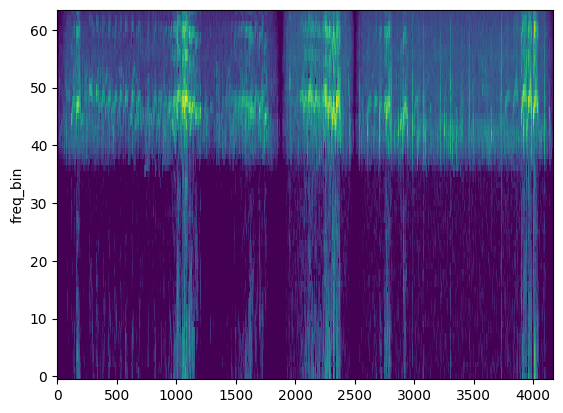

In [15]:
spectrogram_librosa = create_spectrogram_librosa(y_librosa)

plot_torch_spectrogram(spectrogram_librosa)

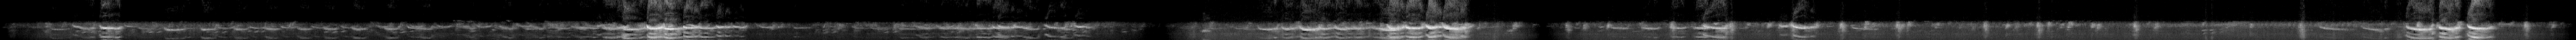

In [16]:
img_torch = plot_librosa_spectrogram(spectrogram_torch)
img_torch

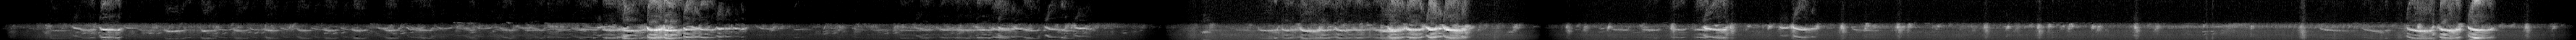

In [17]:
img_librosa = plot_librosa_spectrogram(spectrogram_librosa)
img_librosa

In [18]:
y_librosa

array([-8.8382212e-06, -2.1488815e-06,  2.5660853e-05, ...,
       -3.4472359e-06,  1.2923912e-05, -2.3952089e-07], dtype=float32)

In [19]:
y_torch

tensor([[-5.9474e-07, -8.2828e-06,  3.1757e-05,  ...,  1.9226e-05,
         -1.5389e-06,  8.8210e-06],
        [-1.7082e-05,  3.9851e-06,  1.9564e-05,  ...,  1.8920e-05,
         -5.4965e-06, -5.7358e-06]])

In [20]:
get_loudest_index(y_librosa, n_fft, hop_length)

413824

In [21]:
get_loudest_index(y_torch, n_fft, hop_length)

415360

In [22]:
cut_around_index_librosa(y_librosa, 1035520, sr * sample_length)

array([ 0.00036227,  0.00260668, -0.00055495, ...,  0.00257092,
       -0.00133871, -0.00441845], dtype=float32)

In [23]:
cut_around_index(y_torch, 1035520, sr * sample_length)

tensor([[-0.0003,  0.0025, -0.0005,  ...,  0.0039, -0.0013, -0.0055],
        [ 0.0010,  0.0027, -0.0006,  ...,  0.0013, -0.0014, -0.0033]])

Function: 'create_spectrogram_librosa', execution time: 0.0023496150970458984
Function: 'create_spectrogram_librosa', execution time: 0.003080606460571289


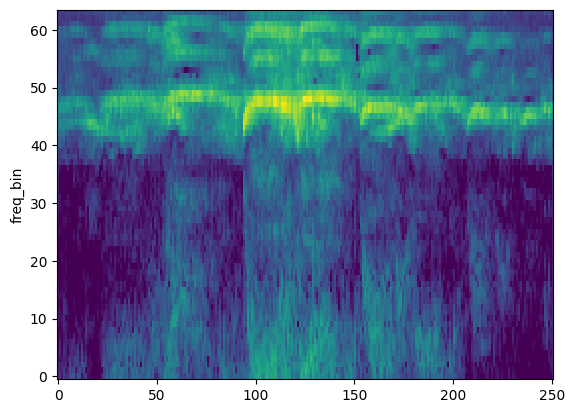

In [25]:
fragments_librosa = get_thresholded_fragments_librosa(y_librosa, sr, n_fft, hop_length, sample_length, 0.7)
spectrograms_librosa = [create_spectrogram_librosa(fragment) for fragment in fragments_librosa]
plot_torch_spectrogram(spectrograms_librosa[0])

In [26]:
fragments_torch = get_thresholded_fragments(y_torch, sr, n_fft, hop_length, sample_length, 0.7)
spectrograms_torch = [create_spectrogram_torch(fragment) for fragment in fragments_torch]
plot_torch_spectrogram(spectrograms_torch[0])

IndexError: index 1081 is out of bounds for axis 0 with size 2